<a href="https://colab.research.google.com/github/lauratomaz/GitHub/blob/master/Copy_of_cifar10_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%matplotlib inline


Training a Classifier
=====================

What about data?
----------------

Generally, when you have to deal with image, text, audio or video data,
you can use standard python packages that load data into a numpy array.
Then you can convert this array into a ``torch.*Tensor``.

-  For images, packages such as Pillow, OpenCV are useful
-  For audio, packages such as scipy and librosa

Specifically for vision, there is a package called
``torchvision``, that has data loaders for common datasets such as
Imagenet, CIFAR10, MNIST, etc. and data transformers for images, viz.,
``torchvision.datasets`` and ``torch.utils.data.DataLoader``.

For this tutorial, we will use the CIFAR10 dataset.
The CIFAR-10 data set is composed of 60,000 32x32 colour images, 6,000 images per class, so 10 categories in total. The training set is made up of 50,000 images, while the remaining 10,000 make up the testing set. The images in CIFAR-10 are of size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.

It has the classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’,
‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’.

![cifar10](https://i2.wp.com/appliedmachinelearning.blog/wp-content/uploads/2018/03/cifar2.jpg?resize=427%2C325&ssl=1)

``Cifar10``


Training an image classifier
----------------------------

We will do the following steps in order:

1. Load and normalizing the CIFAR10 training and test datasets using
   ``torchvision``
2. Define a Convolution Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data

----
1. Loading and normalizing CIFAR10


Using ``torchvision``, it’s extremely easy to load CIFAR10.



In [0]:
import torch
import torchvision
import torchvision.transforms as transforms

This is the two-step process used to prepare the data for use with the convolutional neural network.

First step is to convert Python Image Library (PIL) format to PyTorch tensors.

Second step is used to normalize the data by specifying a mean and standard deviation for each of the three channels. This will convert the data from [0,1] to [-1,1]

Normalization of data should help speed up conversion and reduce the chance of vanishing gradients with certain activation functions.


In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

0it [00:00, ?it/s]

170500096it [00:02, 84980486.50it/s]                               


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Let us show some of the training images.



horse truck horse   cat


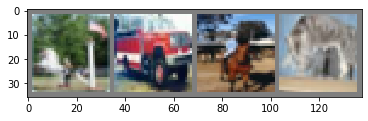

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

2. Define a Convolution Neural Network

 Here, we define the neural network to take 3-channel images. Let's take a look step by step how the neural network processes the input.


1. Input Image: The images are 3x32x32, i.e., 3 channels (red, green, blue) each of size 32x32 pixels.
2. First Convolutional Layer: The first convolutional layer expects 3 input channels and will convolve 6 filters each of size 3x5x5. Since padding is set to 0 and stride is set to 1, the output size is 6x28x28, because (32 − 5) + 1 = 28. This layer therefore has ((5 × 5 × 3) + 1) × 6 = 456 parameters.
3. First Max-Pooling Layer: The first down-sampling layer uses max pooling with a 2x2 kernel and stride set to 2. This effectively drops the size from 6x28x28 to 6x14x14.
4. Second Convolutional Layer: The second convolutional layers expects 6 input channels and will convolve 16 filters each of size 6x5x5. Since padding is set to 0 and stride is set to 1, the output size is 16x10x10, because (14 − 5) + 1 = 10. This layer therefore has ((5 × 5 × 6) + 1) × 16 = 2416 parameters.
5. First Fully-Connected Layer: The output from the final max pooling layer needs to be flattened so that we can connect it to a fully connected layer. This is achieved using the ``torch.Tensor.view`` method. By specifying ``-1`` the method will automatically infer the number of rows required. This is done to handle the mini-batch size of data. The fully-connected layer uses ReLU for activation and has 120 nodes, thus in total it needs ((16 × 5 × 5) + 1) × 120 = 48120 parameters.
6. Second Fully-Connected Layer: The output from the first fully-connected layer is connected to another fully connected layer with 84 nodes, using ReLU as an activation function. This layer thus needs (120 + 1) × 84 = 10164 parameters.
7. Output Layer: The last fully-connected layer uses softmax and is made up of ten nodes, one for each category in CIFAR-10. This layer requires (84 + 1) × 10 = 850 parameters.

Total Network Parameters
This convolutional neural network has a total of 456 + 2416 + 48120 + 10164 + 850 = 62006 parameters.



In [0]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

3. Define a Loss function and optimizer
 
 Let's use a Classification Cross-Entropy loss and SGD with momentum.



In [0]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

4. Train the network

 Here we loop over our data iterator, and feed the inputs to the
network and optimize. 

 We will now train the network using the trainloader data, by going over all the training data in batches of 4 images, and repeating the whole process 2 times, i.e., 2 epochs. Every 2000 batches we report on training progress by printing the current epoch and batch number along with the running loss value.



In [7]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.238
[1,  4000] loss: 1.891
[1,  6000] loss: 1.689
[1,  8000] loss: 1.607
[1, 10000] loss: 1.521
[1, 12000] loss: 1.467
[2,  2000] loss: 1.402
[2,  4000] loss: 1.375
[2,  6000] loss: 1.345
[2,  8000] loss: 1.317
[2, 10000] loss: 1.292
[2, 12000] loss: 1.300
Finished Training


5. Test the network on the test data

 We have trained the network for 2 passes over the training dataset.
But we need to check if the network has learnt anything at all.

 We will check this by predicting the class label that the neural network
outputs, and checking it against the ground-truth. If the prediction is
correct, we add the sample to the list of correct predictions.

 First, let us display an image from the test set to get familiar.



GroundTruth:    cat  ship  ship plane


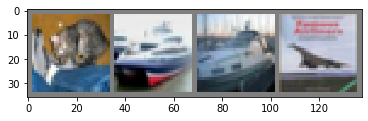

In [8]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

Now, let us see what the neural network thinks these examples above are:



In [0]:
outputs = net(images)

The outputs are accuracy for the 10 classes.
Higher the accuracy for a class, the more the network
thinks that the image is of the particular class.
So, let's get the index of the highest accuracy:



In [10]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat  ship   car  ship


Now, let us look at how the network performs on the whole dataset.



In [12]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 54 %


Our results look better than chance, which is 10% accuracy (randomly picking
a class out of 10 classes).
Seems like the network learnt something.

What are the classes that performed well, and the classes that did
not perform well:



In [25]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
cf_matrix = np.zeros([10,10], int)
with torch.no_grad():
    for data in testloader:
        images, labels = data
        #print(labels)
        outputs = net(images)
        #print(outputs)
        _, predicted = torch.max(outputs, 1)
        #print(predicted)
        c = (predicted == labels).squeeze()
        #print(c)
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
        for i, l in enumerate(labels):
            cf_matrix[l.item(), predicted[i].item()] += 1 


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 45 %
Accuracy of   car : 69 %
Accuracy of  bird : 35 %
Accuracy of   cat : 34 %
Accuracy of  deer : 57 %
Accuracy of   dog : 25 %
Accuracy of  frog : 76 %
Accuracy of horse : 68 %
Accuracy of  ship : 67 %
Accuracy of truck : 63 %


In [0]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

def plot_confusion_matrix(y_true, y_pred, classes, title=None, cmap=plt.cm.Blues):
    
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')
    
    # Rotate the tick labels and set their alignment
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')
    
    # Loop over data dimensions and create text annotations
    thresh = cm.max() / .2
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], 'd'),
                    ha='center', va='center', 
                    color='white' if cm[i, j] > thresh else 'black')
    fig.tight_layout()
    return ax

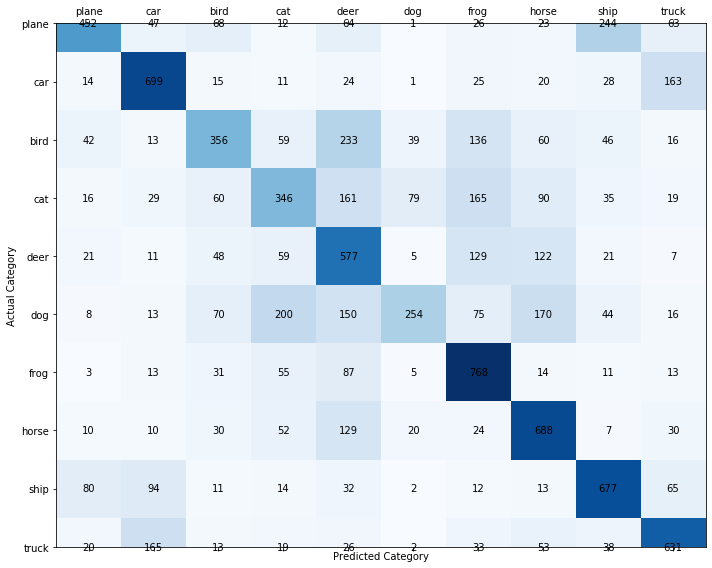

In [38]:
fig, ax = plt.subplots(1,1,figsize=(10,8))
ax.matshow(cf_matrix, aspect='auto', cmap=plt.get_cmap('Blues'))
plt.ylabel('Actual Category')
plt.yticks(range(10), classes)
plt.xlabel('Predicted Category')
plt.xticks(range(10), classes)
for i in range(cf_matrix.shape[0]):
  for j in range(cf_matrix.shape[1]):
    ax.text(j, i, format(cf_matrix[i, j], 'd'),
            ha='center', va='center', 
            color='black')
fig.tight_layout()
plt.show()

Okay, so what next?

How do we run these neural networks on the GPU?

Training on GPU
----------------
Just like how you transfer a Tensor on to the GPU, you transfer the neural
net onto the GPU.

Let's first define our device as the first visible cuda device if we have
CUDA available:



In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assume that we are on a CUDA machine, then this should print a CUDA device:

print(device)

cpu
